In [1]:
import sagemaker
import boto3
from sagemaker.session import s3_input, Session

In [2]:
bucket_name = 'supraja-arima-bitcoindataset' 
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'arima-bitcoin-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://supraja-arima-bitcoindataset/arima-bitcoin-as-a-built-in-algo/output


In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
symbol = ["BTC-USD"]
start_date = "2007-01-02"
features = yf.download(symbol, start=start_date)

[*********************100%***********************]  1 of 1 completed


In [7]:
# Drop multiple columns
features = features.drop(['Open', 'High','Low', 'Adj Close','Volume'], axis=1)

In [8]:
features = features.dropna(axis=0)
features.isna().sum()

Close    0
dtype: int64

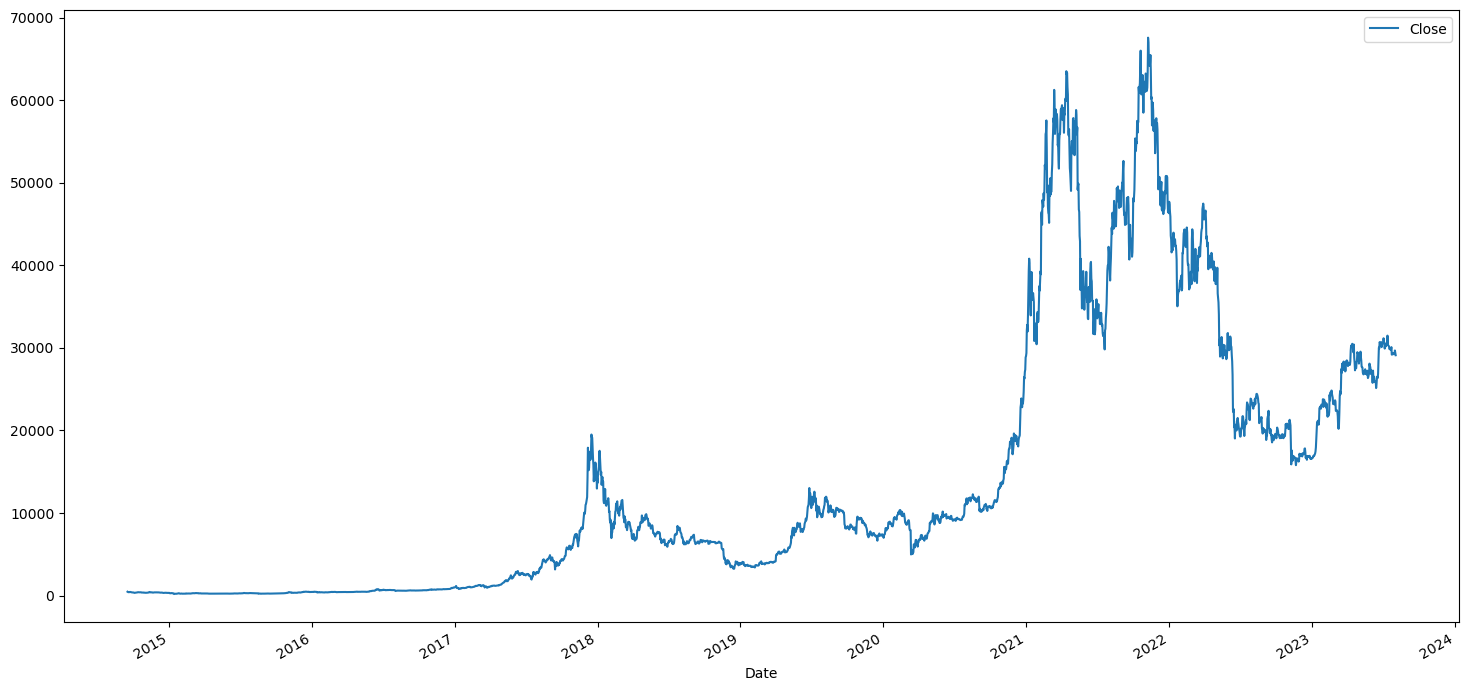

In [9]:
features_plot = pd.DataFrame(features, index=features.index)
# Plot the DataFrame
features_plot.plot(figsize=(18,9))
plt.show()

In [10]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np

In [12]:
df = features 
df.shape

(3242, 1)

In [13]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
  dftest = adfuller(dataset, autolag = "AIC")
  print("1. ADF : " , dftest[0])
  print("2. P-value :" , dftest[1])
  print("3. Num of Lags :" , dftest[2])
  print("4. Num of Observations Used For ADF Regressor and Critical Value Calculations  :" , dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
    print("\t", key,": ", val)

In [14]:
ad_test(df["Close"])

1. ADF :  -1.565010797358713
2. P-value : 0.5011419127052403
3. Num of Lags : 29
4. Num of Observations Used For ADF Regressor and Critical Value Calculations  : 3212
5. Critical Values :
	 1% :  -3.4323875260668344
	 5% :  -2.862440255934873
	 10% :  -2.5672492261933377


In [15]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [16]:
stepwise_fit = auto_arima(df["Close"], trace=True, suppress_warnings = True, stepwise=False, seasonal=False)
stepwise_fit.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52399.459, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52399.351, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52401.016, Time=0.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=52401.731, Time=0.64 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=52399.998, Time=0.94 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=52401.716, Time=1.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52399.307, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=52401.232, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=52401.425, Time=1.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=52401.586, Time=2.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=52402.512, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52401.052, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52400.287, Time=3.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=52384.409, Time=6.57 sec
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3242
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -26185.188
Date:                Thu, 03 Aug 2023   AIC                          52384.376
Time:                        04:40:31   BIC                          52426.961
Sample:                             0   HQIC                         52399.633
                               - 3242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.7546     15.763      0.492      0.623     -23.141      38.650
ar.L1          0.8167      0.012     66.285      0.000       0.793       0.841
ar.L2         -0.9523      0.010    -94.786      0.000      -0.972      -0.933
ar.L3         -0.0032      0.010     -0.326      0.744      -0.022       0.016
ma.L1         -0.8457      0.009    -99.156      0.000      -0.862      -0.829
ma.L2          0.9630      0.008    113.702      0.000       0.946       0.980
sigma2      6.145e+05   5182.720    118.563      0.000    6.04e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             37184.11
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             782.66   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
print(df.shape)
train = df.iloc[:-30]
test = df.iloc[-30:]
print(train.shape,test.shape)

(3242, 1)
(3212, 1) (30, 1)


In [19]:
import os
train_csv = train.to_csv('tesla-arima-train.csv')
test_csv = test.to_csv('tesla-arima-test.csv')

In [20]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/apple-arima-train.csv')).upload_file('apple-arima-train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [ ]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/apple-arima-test.csv')).upload_file('apple-arima-test.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [22]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train["Close"], order=(2,1,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3212
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -25963.697
Date:                Thu, 03 Aug 2023   AIC                          51937.394
Time:                        04:40:32   BIC                          51967.766
Sample:                    09-17-2014   HQIC                         51948.281
                         - 07-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7672      0.297      2.584      0.010       0.185       1.349
ar.L2          0.1886      0.294      0.642      0.521      -0.387       0.764
ma.L1         -0.7913      0.299     -2.646      0.008      -1.378      -0.205
ma.L2         -0.1556      0.295     -0.528      0.598      -0.734       0.422
sigma2      6.192e+05   5097.002    121.480      0.000    6.09e+05    6.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             37593.08
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             844.53   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start,end=end,typ='levels')
pred.index = df.index[start:end+1]
print(pred)

Date
2023-07-04    31163.437262
2023-07-05    31189.637412
2023-07-06    31211.058246
2023-07-07    31232.433420
2023-07-08    31252.872297
2023-07-09    31272.584219
2023-07-10    31291.561844
2023-07-11    31309.839018
2023-07-12    31327.440323
2023-07-13    31344.390999
2023-07-14    31360.715049
2023-07-15    31376.435647
2023-07-16    31391.575100
2023-07-17    31406.154890
2023-07-18    31420.195706
2023-07-19    31433.717474
2023-07-20    31446.739381
2023-07-21    31459.279905
2023-07-22    31471.356841
2023-07-23    31482.987328
2023-07-24    31494.187869
2023-07-25    31504.974358
2023-07-26    31515.362101
2023-07-27    31525.365839
2023-07-28    31534.999767
2023-07-29    31544.277556
2023-07-30    31553.212373
2023-07-31    31561.816894
2023-08-01    31570.103331
2023-08-03    31578.083442
Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

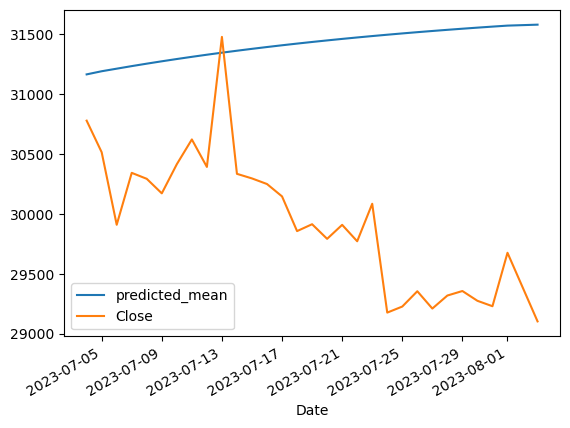

In [24]:
pred.plot(legend=True)
test["Close"].plot(legend=True)

In [25]:
from sklearn.metrics import mean_squared_error 
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test["Close"]))
print(rmse)

1610.7322686814045


In [26]:
test["Close"].mean()

29939.7896484375

In [27]:
model2 = sm.tsa.arima.ARIMA(train["Close"], order=(2,1,2))
model2 = model2.fit()

In [28]:
future_index=pd.date_range(start="2023-05-04", end = "2023-06-02")
pred = model2.predict(start = len(df),end=len(df)+29,typ='levels').rename('ARIMA Prdictions')
pred.index = future_index

In [29]:
pred

2023-05-04    31585.768551
2023-05-05    31593.169563
2023-05-06    31600.296981
2023-05-07    31607.160919
2023-05-08    31613.771117
2023-05-09    31620.136954
2023-05-10    31626.267465
2023-05-11    31632.171348
2023-05-12    31637.856982
2023-05-13    31643.332434
2023-05-14    31648.605474
2023-05-15    31653.683585
2023-05-16    31658.573972
2023-05-17    31663.283576
2023-05-18    31667.819079
2023-05-19    31672.186918
2023-05-20    31676.393290
2023-05-21    31680.444165
2023-05-22    31684.345290
2023-05-23    31688.102202
2023-05-24    31691.720231
2023-05-25    31695.204513
2023-05-26    31698.559990
2023-05-27    31701.791425
2023-05-28    31704.903403
2023-05-29    31707.900340
2023-05-30    31710.786489
2023-05-31    31713.565945
2023-06-01    31716.242653
2023-06-02    31718.820410
Freq: D, Name: ARIMA Prdictions, dtype: float64

In [30]:
output=pred.to_csv('tesla-arima-output.csv')

In [31]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'output/tesla-arima-output.csv')).upload_file('tesla-arima-output.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [32]:
# Calculate RMSE, MAPE, and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test["Close"]))
mape = np.mean(np.abs((test["Close"] - pred) / test["Close"])) * 100
mae = mean_absolute_error(pred, test["Close"])

# Print metrics
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'MAE: {mae:.2f}')

RMSE: 1823.72
MAPE: nan%
MAE: 1723.97
